In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import mplfinance as mplf
import numpy as np
import pandas as pd

import bars
import c
import labels
import signals
import u

# Data Generation

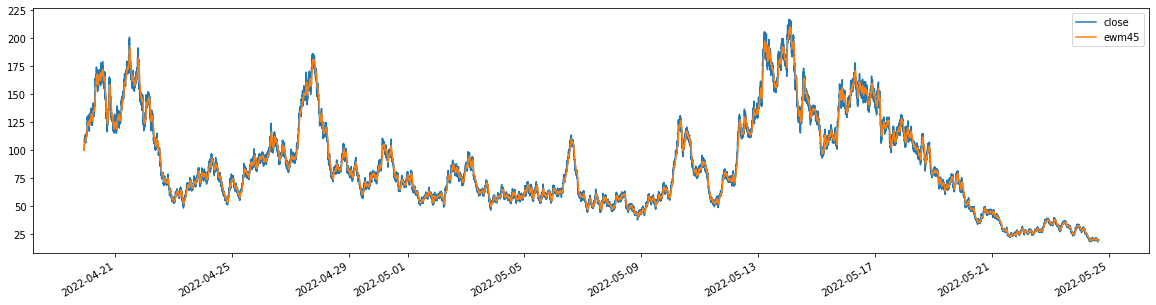

In [3]:
plt.rcParams["figure.figsize"] = (20, 5)

data = u.create_price_data(theta=0.0001, start_price=100, n_samples=50000)
data["ewm45"] = data["close"].ewm(span=45).mean()
data["close"].plot.line()
data["ewm45"].plot.line()
plt.legend()

# Finding Events and Barriers

In [4]:
ewm45 = data["ewm45"]
curr = data["close"]
prev = data["close"].shift(1)
cross_up = (curr > ewm45) & (prev < ewm45)
cross_down = (curr < ewm45) & (prev > ewm45)
data["dir"] = (
    cross_up * c.Dir.B + cross_down * c.Dir.S + (~(cross_up | cross_down)) * c.Dir.U
)
data["trade"] = cross_up | cross_down
data.head()

,close,ewm45,dir,trade
2022-04-19 22:16:46.293079,100.00,100.000000,0,False
2022-04-19 22:17:46.293079,100.33,100.168667,1,True
2022-04-19 22:18:46.293079,101.13,100.503456,1,True
2022-04-19 22:19:46.293079,101.56,100.785456,0,False
2022-04-19 22:20:46.293079,101.66,100.976250,0,False


In [5]:
resampled = data.resample("H")
target = np.mean((resampled["close"].last() / resampled["close"].first()).std())
price_target = 1
stop_loss = 1
vertical_barrier = np.timedelta64(1, "h")

In [6]:
indices = data.loc[data["trade"]].index
barriers = signals.get_price_target_stop_loss_indices(
    data,
    indices,
    target=target,
    side=data.loc[indices, "dir"],
    price_target=price_target,
    stop_loss=stop_loss,
    vertical_barrier=vertical_barrier,
)
barriers = signals.add_profit_target_stop_loss_outcome(barriers)
barriers.head()

,pt_dt,sl_dt,side,vb,pt_sl,pt
2022-04-19 22:17:46.293079,2022-04-19 22:39:46.293079,NaT,1,0 days 01:00:00,1,True
2022-04-19 22:18:46.293079,2022-04-19 22:40:46.293079,NaT,1,0 days 01:00:00,1,True
2022-04-19 23:14:46.293079,NaT,NaT,-1,0 days 01:00:00,0,False
2022-04-19 23:18:46.293079,NaT,NaT,1,0 days 01:00:00,0,False
2022-04-19 23:28:46.293079,NaT,NaT,-1,0 days 01:00:00,0,False


# Concurrent Labels

In [7]:
counts = labels.get_concurrent_label_count(data, barriers)
counts.name = "counts"
counts.head()

2022-04-19 22:16:46.293079    0
2022-04-19 22:17:46.293079    1
2022-04-19 22:18:46.293079    2
2022-04-19 22:19:46.293079    2
2022-04-19 22:20:46.293079    2
Freq: T, Name: counts, dtype: int64

# Uniqueness

<AxesSubplot:>

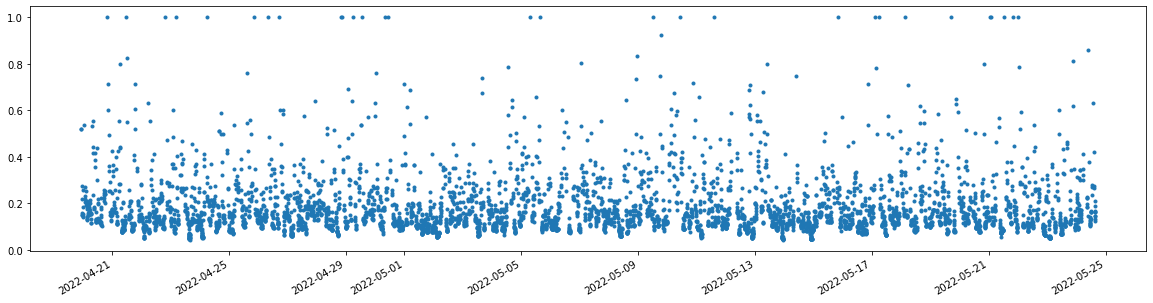

In [15]:
uniqueness = labels.get_label_uniqueness(barriers, counts)
uniqueness.plot(style=".")

<AxesSubplot:>

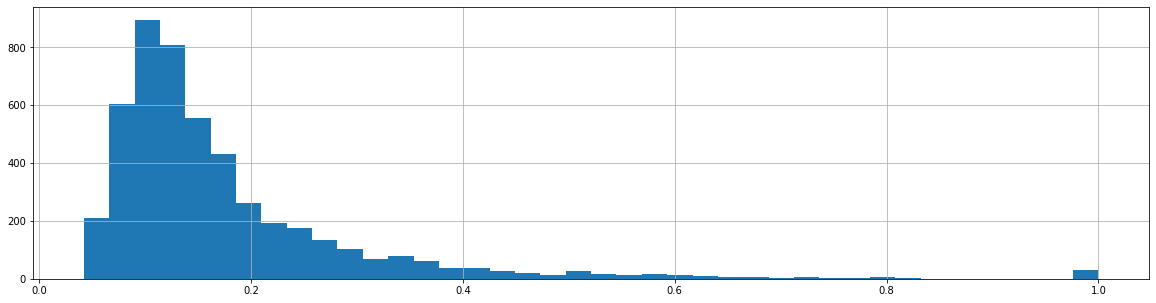

In [28]:
uniqueness.hist(bins=40)

# Test Autocorrelation Of Counts Using NB GLM

In [ ]:
import statsmodels.api as sm

model = sm.NegativeBinomial(counts[:-1].to_numpy(), counts[1:]).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.930331
         Iterations: 10
         Function evaluations: 14
         Gradient evaluations: 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                      y   No. Observations:                49999
Model:               NegativeBinomial   Df Residuals:                    49998
Method:                           MLE   Df Model:                            0
Date:                Tue, 24 May 2022   Pseudo R-squ.:                  0.2594
Time:                        20:58:13   Log-Likelihood:                -96515.
converged:                       True   LL-Null:                   -1.3032e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
counts         0.2223      0.000    591.765      0.000       0.222       0.223
alpha          0.0959      0.002     62.620      0.000       0.093       0.099
==============================================================================
"""

# Test Autocorrelation of Uniqueness Using Binomial GLM 

In [54]:
model = sm.GLM(
    uniqueness[:-1].to_numpy(), uniqueness[1:], family=sm.families.Binomial()
).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 4888
Model:                            GLM   Df Residuals:                     4887
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2229.0
Date:                Tue, 24 May 2022   Deviance:                       1618.4
Time:                        22:18:42   Pearson chi2:                 3.38e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            -0.2663
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -5.5537      0.198    -28.086      0.000      -5.941      -5.166
==============================================================================
"""